# Risk Factors and COVID-19 Diagnosis in Mexico

## Objective

We need a model that will tell us which at-risk individuals are likely to test positive for COVID-19 so that health workers can target testing resources and health education toward that population.

Import some basic libraries:
* Pandas - provided data frames
* matplotlib.pyplot - plotting support
* numpy - data shuffling

**Use Magic %matplotlib to display graphics inline instead of in a popup window.**

In [1]:
import pandas as pd # pandas is a dataframe library
import matplotlib.pyplot as plt # matplotlib.pyplot plots data
import numpy as np
import boto3
%matplotlib inline

## Table of Contents

1. Loading the Data
2. Preprocess the loaded data
3. Feature Transformation and Engineering
   1. Feature Transformation
       1. Remove rows based on condition
       2. Drop Unused Columns
       3. Check Category Distribution
   2. Feature Engineering 
       1. Create risk score based on comorbidities (other diseases, treatment delay, and COVID-19 contact)
       2. Calculating the number of days the patient waited before being checked
       3. Adding more quanititative metrics about the population of the residence the patient is in and Human Development Index     
4. Exploratory Data Analysis

# 1. Loading the Data

Open Data - Mexico General Directorate of Epidemiology - Daily Updates 
https://www.gob.mx/salud/documentos/datos-abiertos-152127


In [18]:
#data = pd.read_csv('200813COVID19MEXICO.csv', encoding='latin-1')
bucket='aws-covid19-hackathonteam4' # Or whatever you called your bucket
data_key = '200813COVID19MEXICO.csv' # Where the file is within your bucket
data_location = 's3://{}/{}'.format(bucket, data_key)
data = pd.read_csv(data_location,encoding='latin-1')

In [19]:
Number_of_points = data.shape

### RENAME COLUMNS IN THE DATA FRAME

In [20]:
data.rename(columns = {'FECHA_ACTUALIZACION':'batch_date','ID_REGISTRO':'identifier','ORIGEN':'sentinel_surveillance','SECTOR':'health_system_type',
                       'ENTIDAD_UM':'medical_facility_location','SEXO':'gender','ENTIDAD_NAC':'birthplace','ENTIDAD_RES':'residence',
                       'MUNICIPIO_RES':'muncipality_res','TIPO_PACIENTE':'patient_type','FECHA_INGRESO':'admission_date','FECHA_SINTOMAS':'symptomatic_date',
                       'FECHA_DEF':'death_date','INTUBADO':'intubated','NEUMONIA':'pneumonia','EDAD':'age','NACIONALIDAD':'mexican','EMBARAZO':'pregnant',
                       'HABLA_LENGUA_INDIG':'speak_native_language','DIABETES':'diabetes','EPOC':'copd','ASMA':'asthma','INMUSUPR':'immuno','HIPERTENSION':'hypertension',
                       'OTRA_COM':'other_disease','CARDIOVASCULAR':'cardiovascular','OBESIDAD':'obesity','RENAL_CRONICA':'chronic_renal_failure','TABAQUISMO':'tobacco',
                       'OTRO_CASO':'other_covid_contact','RESULTADO':'covid_test_result','MIGRANTE':'migrant','PAIS_NACIONALIDAD':'nationality','PAIS_ORIGEN':'travel_from','UCI':'icu'}, inplace = True) 

Check for NULL values

In [21]:
#Records that need to be removed because they are null or empty
data.isnull().sum()

batch_date                   0
identifier                   0
sentinel_surveillance        0
health_system_type           0
medical_facility_location    0
gender                       0
birthplace                   0
residence                    0
muncipality_res              0
patient_type                 0
admission_date               0
symptomatic_date             0
death_date                   0
intubated                    0
pneumonia                    0
age                          0
mexican                      0
pregnant                     0
speak_native_language        0
diabetes                     0
copd                         0
asthma                       0
immuno                       0
hypertension                 0
other_disease                0
cardiovascular               0
obesity                      0
chronic_renal_failure        0
tobacco                      0
other_covid_contact          0
covid_test_result            0
migrant                      0
national

In [22]:
#REMOVE ALL RECORDS THAT ARE NaN
data.dropna(inplace=True)

In [23]:
# display all columns
pd.set_option('display.max_columns', None)

# display first few records
data.head(15)

,batch_date,identifier,sentinel_surveillance,health_system_type,medical_facility_location,gender,birthplace,residence,muncipality_res,patient_type,admission_date,symptomatic_date,death_date,intubated,pneumonia,age,mexican,pregnant,speak_native_language,diabetes,copd,asthma,immuno,hypertension,other_disease,cardiovascular,obesity,chronic_renal_failure,tobacco,other_covid_contact,covid_test_result,migrant,nationality,travel_from,icu
0,2020-08-12,13f301,2,3,15,2,9,15,106,2,2020-05-27,2020-05-25,9999-99-99,2,2,54,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,99,MÃ©xico,99,2
1,2020-08-12,1cb5dc,2,3,2,2,2,2,2,2,2020-06-07,2020-06-06,2020-06-09,1,1,67,1,97,2,2,2,2,1,1,1,2,1,2,2,1,1,99,MÃ©xico,99,2
2,2020-08-12,0e7edf,2,3,27,2,27,27,4,1,2020-06-18,2020-06-08,9999-99-99,97,2,31,1,97,2,2,2,2,2,2,2,2,2,2,1,1,1,99,MÃ©xico,99,97
3,2020-08-12,024f30,2,4,9,2,9,15,58,1,2020-04-08,2020-04-02,9999-99-99,97,2,34,1,97,2,2,2,2,2,2,2,2,1,2,2,99,1,99,MÃ©xico,99,97
4,2020-08-12,1e6e4c,2,4,25,2,25,25,11,1,2020-04-20,2020-04-17,9999-99-99,97,2,31,1,97,2,2,2,2,2,1,2,2,2,2,2,99,1,99,MÃ©xico,99,97
5,2020-08-12,03877c,2,3,25,1,25,25,6,2,2020-05-20,2020-05-13,2020-06-09,1,1,52,1,2,2,2,2,2,2,2,2,2,1,2,2,99,1,99,MÃ©xico,99,2
6,2020-08-12,1adbdb,2,3,2,2,26,2,2,1,2020-06-01,2020-06-01,9999-99-99,97,2,44,1,97,2,2,2,2,2,2,2,2,2,2,2,1,1,99,MÃ©xico,99,97
7,2020-08-12,16ef4d,2,3,15,2,15,15,106,1,2020-06-16,2020-06-14,9999-99-99,97,1,33,1,97,2,2,2,2,2,2,2,2,1,2,1,2,1,99,MÃ©xico,99,97
8,2020-08-12,17842c,2,4,31,2,20,31,50,1,2020-04-08,2020-04-07,9999-99-99,97,2,42,1,97,2,2,2,2,2,2,2,2,1,2,1,99,1,99,MÃ©xico,99,97
9,2020-08-12,11a9b3,2,4,9,2,9,15,58,1,2020-04-20,2020-04-20,9999-99-99,97,2,32,1,97,2,2,2,2,2,1,2,2,2,2,2,99,1,99,MÃ©xico,99,97


# 2. Preprocess the loaded data

In [24]:
# verify data types
data.dtypes

batch_date                   object
identifier                   object
sentinel_surveillance         int64
health_system_type            int64
medical_facility_location     int64
gender                        int64
birthplace                    int64
residence                     int64
muncipality_res               int64
patient_type                  int64
admission_date               object
symptomatic_date             object
death_date                   object
intubated                     int64
pneumonia                     int64
age                           int64
mexican                       int64
pregnant                      int64
speak_native_language         int64
diabetes                      int64
copd                          int64
asthma                        int64
immuno                        int64
hypertension                  int64
other_disease                 int64
cardiovascular                int64
obesity                       int64
chronic_renal_failure       

In [25]:
#Preprocess the date variables
# change death_date to datetime data type
data['admission_date']= pd.to_datetime(data['admission_date']) 
#create new column, days_treatment_delay by subtracting admission date from symptomatic date to determine days delayed seeking treatment
# change death_date to datetime data type
data['symptomatic_date']= pd.to_datetime(data['symptomatic_date']) 

In [26]:
# change data types to int
data['age'] = data['age'].astype(int)
data['intubated'] = data['intubated'].astype(int)
data['other_covid_contact'] = data['other_covid_contact'].astype(int)
data['covid_test_result'] = data['covid_test_result'].astype(int)

In [27]:
#replace date placeholder "9999-99-99" value with nonsense real date value of 1-1-1900
data['death_date'] = data['death_date'].replace(['9999-99-99'],['1900-01-01']) 
# change death_date to datetime data type
data['death_date'] = pd.to_datetime(data['death_date'])

In [28]:
data.head(15)

,batch_date,identifier,sentinel_surveillance,health_system_type,medical_facility_location,gender,birthplace,residence,muncipality_res,patient_type,admission_date,symptomatic_date,death_date,intubated,pneumonia,age,mexican,pregnant,speak_native_language,diabetes,copd,asthma,immuno,hypertension,other_disease,cardiovascular,obesity,chronic_renal_failure,tobacco,other_covid_contact,covid_test_result,migrant,nationality,travel_from,icu
0,2020-08-12,13f301,2,3,15,2,9,15,106,2,2020-05-27,2020-05-25,1900-01-01,2,2,54,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,99,MÃ©xico,99,2
1,2020-08-12,1cb5dc,2,3,2,2,2,2,2,2,2020-06-07,2020-06-06,2020-06-09,1,1,67,1,97,2,2,2,2,1,1,1,2,1,2,2,1,1,99,MÃ©xico,99,2
2,2020-08-12,0e7edf,2,3,27,2,27,27,4,1,2020-06-18,2020-06-08,1900-01-01,97,2,31,1,97,2,2,2,2,2,2,2,2,2,2,1,1,1,99,MÃ©xico,99,97
3,2020-08-12,024f30,2,4,9,2,9,15,58,1,2020-04-08,2020-04-02,1900-01-01,97,2,34,1,97,2,2,2,2,2,2,2,2,1,2,2,99,1,99,MÃ©xico,99,97
4,2020-08-12,1e6e4c,2,4,25,2,25,25,11,1,2020-04-20,2020-04-17,1900-01-01,97,2,31,1,97,2,2,2,2,2,1,2,2,2,2,2,99,1,99,MÃ©xico,99,97
5,2020-08-12,03877c,2,3,25,1,25,25,6,2,2020-05-20,2020-05-13,2020-06-09,1,1,52,1,2,2,2,2,2,2,2,2,2,1,2,2,99,1,99,MÃ©xico,99,2
6,2020-08-12,1adbdb,2,3,2,2,26,2,2,1,2020-06-01,2020-06-01,1900-01-01,97,2,44,1,97,2,2,2,2,2,2,2,2,2,2,2,1,1,99,MÃ©xico,99,97
7,2020-08-12,16ef4d,2,3,15,2,15,15,106,1,2020-06-16,2020-06-14,1900-01-01,97,1,33,1,97,2,2,2,2,2,2,2,2,1,2,1,2,1,99,MÃ©xico,99,97
8,2020-08-12,17842c,2,4,31,2,20,31,50,1,2020-04-08,2020-04-07,1900-01-01,97,2,42,1,97,2,2,2,2,2,2,2,2,1,2,1,99,1,99,MÃ©xico,99,97
9,2020-08-12,11a9b3,2,4,9,2,9,15,58,1,2020-04-20,2020-04-20,1900-01-01,97,2,32,1,97,2,2,2,2,2,1,2,2,2,2,2,99,1,99,MÃ©xico,99,97


# **Feature Transformation and Engineering**

The following features will be used to indicate a patient who is high risk for COVID-19. 

## A. Feature explanation


1. age - feature that denotes patient's age

2. days_treatment_delay - feature that denotes number of days that patient delayed seeking medical care after becoming symptomatic

3. risk_score - aggregate score denoting number of comorbidities for patient as well as known COVID-19 contact

4. residence - feature that denotes the state the patient resides in

5. municipality_res - feature that denotes the municipality the patient resides in

6. hdi - Human Development Index (average of the subnational values of 3 dimensions: education, health, and standard of living)

7. pop - total population by state

8. covid_test_result - feature that denotes COVID-19 diagnosis 

See number of rows and columns.

In [29]:
data.shape

(1127115, 35)

In [30]:
data.tail(10)

,batch_date,identifier,sentinel_surveillance,health_system_type,medical_facility_location,gender,birthplace,residence,muncipality_res,patient_type,admission_date,symptomatic_date,death_date,intubated,pneumonia,age,mexican,pregnant,speak_native_language,diabetes,copd,asthma,immuno,hypertension,other_disease,cardiovascular,obesity,chronic_renal_failure,tobacco,other_covid_contact,covid_test_result,migrant,nationality,travel_from,icu
1127105,2020-08-12,19c032,2,4,14,1,9,14,39,2,2020-07-16,2020-07-06,1900-01-01,2,2,29,1,2,2,1,2,2,2,1,2,1,2,2,1,99,3,99,MÃ©xico,99,2
1127106,2020-08-12,188acd,2,12,28,2,28,28,41,1,2020-08-08,2020-08-05,1900-01-01,97,2,39,1,97,99,2,2,2,2,2,2,2,2,2,2,2,3,99,MÃ©xico,99,97
1127107,2020-08-12,18aace,2,12,9,1,9,9,8,1,2020-08-08,2020-07-27,1900-01-01,97,2,51,1,2,2,2,2,2,2,2,2,1,1,2,2,2,3,99,MÃ©xico,99,97
1127108,2020-08-12,0e6ab3,2,9,9,2,15,15,58,2,2020-08-07,2020-08-04,1900-01-01,2,1,53,1,97,2,2,2,2,2,2,2,2,2,2,2,1,3,99,MÃ©xico,99,2
1127109,2020-08-12,180b94,2,12,9,1,9,15,81,1,2020-08-08,2020-08-07,1900-01-01,97,2,14,1,2,2,2,2,2,2,2,2,2,2,2,2,2,3,99,MÃ©xico,99,97
1127110,2020-08-12,028e20,2,12,24,2,24,24,21,1,2020-07-29,2020-07-24,1900-01-01,97,2,76,1,97,2,1,2,2,2,2,2,2,2,2,2,1,3,99,MÃ©xico,99,97
1127111,2020-08-12,096cf0,2,4,25,2,25,25,1,1,2020-08-09,2020-07-30,1900-01-01,97,2,48,1,97,2,2,2,2,2,2,2,2,2,2,2,99,3,99,MÃ©xico,99,97
1127112,2020-08-12,01bc01,2,12,16,1,16,16,53,1,2020-08-09,2020-08-02,1900-01-01,97,2,38,1,2,2,2,2,2,2,2,2,2,2,2,2,1,3,99,MÃ©xico,99,97
1127113,2020-08-12,11673c,2,4,30,2,30,30,44,2,2020-08-08,2020-08-08,1900-01-01,2,2,70,1,97,2,2,2,2,2,2,2,2,2,2,1,99,3,99,MÃ©xico,99,2
1127114,2020-08-12,1deef3,2,12,24,1,24,24,20,1,2020-08-09,2020-08-06,1900-01-01,97,2,35,1,2,2,2,2,2,2,2,2,2,2,2,2,2,3,99,MÃ©xico,99,97


#### a. Remove rows based on condition

In [31]:
def remove_the_feature_from_dataframe(data,feature,value):
    indexNames = data[data[feature] == value].index 
    data.drop(indexNames , inplace=True)
 

In [32]:
print(set(data['covid_test_result']))
remove_the_feature_from_dataframe(data,'covid_test_result',3)
data['covid_test_result'] = data['covid_test_result'].replace([2],[0])

{1, 2, 3}


In [33]:
for feature in ['other_covid_contact','pneumonia','copd','diabetes','cardiovascular','chronic_renal_failure','obesity','hypertension'\
               ,'immuno','tobacco','icu','intubated','gender','patient_type', 'asthma']:
    print(feature,set(data[feature]))
     

other_covid_contact {1, 2, 99}
pneumonia {1, 2, 99}
copd {1, 2, 98}
diabetes {1, 2, 98}
cardiovascular {1, 2, 98}
chronic_renal_failure {1, 2, 98}
obesity {1, 2, 98}
hypertension {1, 2, 98}
immuno {1, 2, 98}
tobacco {1, 2, 98}
icu {97, 2, 99, 1}
intubated {1, 2, 99, 97}
gender {1, 2}
patient_type {1, 2}


In [34]:
transformed_data = data.copy()
test_data = data.copy()

In [35]:
#Get remove indexes for which columns of interest has unknown values
for feature in ['other_covid_contact','pneumonia','copd','diabetes','cardiovascular','chronic_renal_failure','obesity','hypertension'\
               ,'immuno','tobacco','patient_type','icu','intubated', 'asthma']:
    for value in [97,98,99]:
        remove_the_feature_from_dataframe(test_data,feature,value)
    New_Number_of_points = test_data.shape
    print('Feature analyzed',feature)
    print('The data was reduced to {}%'.format(round(100*(New_Number_of_points[0]/Number_of_points[0])),2))
    test_data[feature] = test_data[feature].replace([2],[0])

Feature analyzed other_covid_contact
The data was reduced to 65%
Feature analyzed pneumonia
The data was reduced to 65%
Feature analyzed copd
The data was reduced to 65%
Feature analyzed diabetes
The data was reduced to 65%
Feature analyzed cardiovascular
The data was reduced to 65%
Feature analyzed chronic_renal_failure
The data was reduced to 65%
Feature analyzed obesity
The data was reduced to 65%
Feature analyzed hypertension
The data was reduced to 65%
Feature analyzed immuno
The data was reduced to 65%
Feature analyzed tobacco
The data was reduced to 65%
Feature analyzed patient_type
The data was reduced to 65%
Feature analyzed icu
The data was reduced to 8%
Feature analyzed intubated
The data was reduced to 8%


In [36]:
for feature in ['other_covid_contact','pneumonia','copd','diabetes','cardiovascular','chronic_renal_failure','obesity','hypertension'\
               ,'immuno','tobacco','icu','intubated','gender','patient_type', 'asthma']:
    print(feature,set(test_data[feature]))

other_covid_contact {0, 1}
pneumonia {0, 1}
copd {0, 1}
diabetes {0, 1}
cardiovascular {0, 1}
chronic_renal_failure {0, 1}
obesity {0, 1}
hypertension {0, 1}
immuno {0, 1}
tobacco {0, 1}
icu {0, 1}
intubated {0, 1}
gender {1, 2}
patient_type {0}


In [37]:
#Get remove indexes for which columns of interest has unknown values
for feature in ['other_covid_contact','pneumonia','copd','diabetes','cardiovascular','chronic_renal_failure','obesity','hypertension'\
               ,'immuno','tobacco','patient_type', 'asthma']:
    for value in [97,98,99]:
        remove_the_feature_from_dataframe(transformed_data,feature,value)
    New_Number_of_points = transformed_data.shape
    print('Feature analyzed',feature)
    print('The data was reduced to {}%'.format(round(100*(New_Number_of_points[0]/Number_of_points[0])),2))
    transformed_data[feature] = transformed_data[feature].replace([2],[0])

Feature analyzed other_covid_contact
The data was reduced to 65%
Feature analyzed pneumonia
The data was reduced to 65%
Feature analyzed copd
The data was reduced to 65%
Feature analyzed diabetes
The data was reduced to 65%
Feature analyzed cardiovascular
The data was reduced to 65%
Feature analyzed chronic_renal_failure
The data was reduced to 65%
Feature analyzed obesity
The data was reduced to 65%
Feature analyzed hypertension
The data was reduced to 65%
Feature analyzed immuno
The data was reduced to 65%
Feature analyzed tobacco
The data was reduced to 65%
Feature analyzed patient_type
The data was reduced to 65%


In [38]:
for feature in ['other_covid_contact','pneumonia','copd','diabetes','cardiovascular','chronic_renal_failure','obesity','hypertension'\
               ,'immuno','tobacco','icu','intubated','gender','patient_type', 'asthma']:
    print(feature,set(transformed_data[feature]))
    
transformed_data['gender'] = transformed_data['gender'].replace([2],[0])

other_covid_contact {0, 1}
pneumonia {0, 1}
copd {0, 1}
diabetes {0, 1}
cardiovascular {0, 1}
chronic_renal_failure {0, 1}
obesity {0, 1}
hypertension {0, 1}
immuno {0, 1}
tobacco {0, 1}
icu {97, 2, 99, 1}
intubated {1, 2, 99, 97}
gender {1, 2}
patient_type {0, 1}


In [39]:
transformed_data.tail(10)

,batch_date,identifier,sentinel_surveillance,health_system_type,medical_facility_location,gender,birthplace,residence,muncipality_res,patient_type,admission_date,symptomatic_date,death_date,intubated,pneumonia,age,mexican,pregnant,speak_native_language,diabetes,copd,asthma,immuno,hypertension,other_disease,cardiovascular,obesity,chronic_renal_failure,tobacco,other_covid_contact,covid_test_result,migrant,nationality,travel_from,icu
1064129,2020-08-12,0c7a69,2,12,15,0,9,15,122,1,2020-08-03,2020-08-01,1900-01-01,97,0,30,1,97,2,0,0,2,0,0,2,0,0,0,1,0,0,99,MÃ©xico,99,97
1064130,2020-08-12,064b89,2,12,28,0,28,28,41,1,2020-08-03,2020-08-02,1900-01-01,97,0,41,1,97,2,0,0,2,0,0,2,0,0,0,0,1,0,99,MÃ©xico,99,97
1064131,2020-08-12,12208f,2,12,9,1,9,15,58,1,2020-08-03,2020-07-30,1900-01-01,97,0,16,1,2,2,0,0,2,0,0,2,0,0,0,0,0,0,99,MÃ©xico,99,97
1064132,2020-08-12,052d04,1,12,19,0,8,19,48,1,2020-08-03,2020-07-31,1900-01-01,97,0,71,1,97,2,0,0,2,0,0,2,0,0,0,0,0,0,99,MÃ©xico,99,97
1064134,2020-08-12,07f7a8,1,12,13,1,13,13,38,1,2020-07-29,2020-07-28,1900-01-01,97,0,25,1,2,2,0,0,2,0,0,2,0,0,0,0,1,0,99,MÃ©xico,99,97
1064135,2020-08-12,0e636d,2,12,9,0,9,9,17,1,2020-07-29,2020-07-26,1900-01-01,97,0,64,1,97,2,1,0,2,0,1,2,0,0,0,1,1,0,99,MÃ©xico,99,97
1064136,2020-08-12,0e162c,2,12,15,1,15,15,13,1,2020-07-27,2020-07-25,1900-01-01,97,0,47,1,2,2,0,0,2,0,0,2,0,1,0,0,1,0,99,MÃ©xico,99,97
1064137,2020-08-12,0a245c,2,12,21,0,21,21,114,1,2020-07-29,2020-07-22,1900-01-01,97,0,18,1,97,2,0,0,2,0,0,2,0,0,0,0,1,0,99,MÃ©xico,99,97
1064138,2020-08-12,19f9c8,2,12,3,1,3,3,3,1,2020-08-03,2020-08-01,1900-01-01,97,0,47,1,2,2,0,0,2,0,0,2,0,0,0,0,1,0,99,MÃ©xico,99,97
1064139,2020-08-12,10fba5,2,6,20,1,20,20,82,1,2020-08-03,2020-08-01,1900-01-01,97,0,38,1,2,2,0,0,2,0,0,2,0,0,0,0,1,0,99,MÃ©xico,99,97


In [40]:
transformed_data.head(10)

,batch_date,identifier,sentinel_surveillance,health_system_type,medical_facility_location,gender,birthplace,residence,muncipality_res,patient_type,admission_date,symptomatic_date,death_date,intubated,pneumonia,age,mexican,pregnant,speak_native_language,diabetes,copd,asthma,immuno,hypertension,other_disease,cardiovascular,obesity,chronic_renal_failure,tobacco,other_covid_contact,covid_test_result,migrant,nationality,travel_from,icu
0,2020-08-12,13f301,2,3,15,0,9,15,106,0,2020-05-27,2020-05-25,1900-01-01,2,0,54,1,97,2,0,0,2,0,0,2,0,0,0,0,0,1,99,MÃ©xico,99,2
1,2020-08-12,1cb5dc,2,3,2,0,2,2,2,0,2020-06-07,2020-06-06,2020-06-09,1,1,67,1,97,2,0,0,2,1,1,1,0,1,0,0,1,1,99,MÃ©xico,99,2
2,2020-08-12,0e7edf,2,3,27,0,27,27,4,1,2020-06-18,2020-06-08,1900-01-01,97,0,31,1,97,2,0,0,2,0,0,2,0,0,0,1,1,1,99,MÃ©xico,99,97
6,2020-08-12,1adbdb,2,3,2,0,26,2,2,1,2020-06-01,2020-06-01,1900-01-01,97,0,44,1,97,2,0,0,2,0,0,2,0,0,0,0,1,1,99,MÃ©xico,99,97
7,2020-08-12,16ef4d,2,3,15,0,15,15,106,1,2020-06-16,2020-06-14,1900-01-01,97,1,33,1,97,2,0,0,2,0,0,2,0,1,0,1,0,1,99,MÃ©xico,99,97
12,2020-08-12,18f860,2,3,2,1,2,2,2,0,2020-05-27,2020-05-27,1900-01-01,2,1,59,1,2,2,1,0,2,0,0,2,0,0,0,0,1,1,99,MÃ©xico,99,2
13,2020-08-12,1057de,2,3,15,0,15,15,33,1,2020-06-19,2020-06-16,1900-01-01,97,0,33,1,97,2,0,0,2,0,0,2,0,0,0,0,1,1,99,MÃ©xico,99,97
14,2020-08-12,0b79a6,2,3,15,1,9,15,106,1,2020-07-01,2020-06-28,1900-01-01,97,0,30,1,2,2,0,0,2,0,0,2,0,1,0,0,1,1,99,MÃ©xico,99,97
18,2020-08-12,1268a4,2,3,15,0,15,15,115,0,2020-06-12,2020-06-10,1900-01-01,2,0,45,1,97,2,0,0,2,0,0,2,0,0,0,0,0,1,99,MÃ©xico,99,2
26,2020-08-12,1779cd,2,3,15,0,15,15,106,0,2020-05-27,2020-05-25,1900-01-01,2,1,58,1,97,2,1,0,2,0,1,2,0,0,0,0,0,1,99,MÃ©xico,99,2


#### b. Drop Unused Columns 

In [41]:
# remove the columns that will not be used for the model
transformed_data.drop(columns=['travel_from','mexican','nationality','migrant','speak_native_language','batch_date','identifier','sentinel_surveillance','pregnant','death_date','birthplace','intubated','icu'],axis=1,inplace=True)


#### c. Check Category Distribution

In [42]:
pd.crosstab(transformed_data.gender, transformed_data.covid_test_result)

covid_test_result,0,1
gender,,
0,193885,167504
1,216663,152452


### B. Feature Engineering 

#### a. CREATE RISK SCORE BASED ON COMORBIDITIES (OTHER DISEASES, TREATMENT DELAY, AND OTHER COVID CONTACT)

In [43]:
risk_score_columns = ['pneumonia','copd','diabetes','cardiovascular','chronic_renal_failure','obesity','hypertension'\
               ,'immuno','tobacco','other_disease','asthma']
sum_column = transformed_data[risk_score_columns[0]]
if len(risk_score_columns)>1:
    for i in range(1,len(risk_score_columns)):
     sum_column = sum_column + data[risk_score_columns[i]]

In [44]:
transformed_data['risk_score'] = round(sum_column/len(risk_score_columns),2)
transformed_data.drop(columns=risk_score_columns,axis=1,inplace=True)
pd.crosstab(data.gender, data.covid_test_result)

covid_test_result,0,1
gender,,
1,290436,234810
2,254826,263570


#### b. Calculating the number of days the patient waited before being checked

In [45]:
# Calculates the treatment delays
transformed_data['days_treatment_delay'] = transformed_data['admission_date'].sub(transformed_data['symptomatic_date'], axis=0)
# change days_treatment_delay to proper integer with no decimal
transformed_data['days_treatment_delay'] = (transformed_data['days_treatment_delay'] / np.timedelta64(1, 'D')).astype(int)
'''
# change data types to int
# set delayed column to 1 if treatment delayed days greater than 2, otherwise set to 0
def delayed(c):
  if c['days_treatment_delay'] > 2:
    return '1'
  else:
    return '0'
transformed_data['delayed'] = transformed_data.apply(delayed, axis=1)
transformed_data['delayed'] = transformed_data['delayed'].astype(int)
'''
#normalize days_treatment_delay
transformed_data['days_treatment_delay'] = round((transformed_data['days_treatment_delay'] -transformed_data['days_treatment_delay'].mean())/transformed_data['days_treatment_delay'].std(),2)
transformed_data.drop(columns=['symptomatic_date','admission_date'],inplace=True)

In [46]:
# Put patients into different catergories
transformed_data['age_by_category'] = pd.cut(transformed_data.age,bins=[0,2,12,17,65,99,125],labels=['Infant','Child','Teen', 'Adult','Elderly','Centenarian'], right=False,include_lowest=True)

# create new column for age category class value

age_map={
'Infant' : 1,
'Child' : 2,
'Teen' : 3,
'Adult' : 4,
'Elderly' : 5,
'Centenarian' : 6
}
transformed_data['age_cat'] = transformed_data['age_by_category'].map(age_map)

transformed_data['age_by_category'].value_counts(normalize=True)
print(set(transformed_data['age_by_category']))
print(set(transformed_data['age_cat']))
transformed_data.drop(columns=['age','age_by_category'],inplace=True)
transformed_data.dropna(inplace=True)
transformed_data['age_cat'] = transformed_data['age_cat'].astype(int)

{'Elderly', nan, 'Teen', 'Adult', 'Infant', 'Child'}
{0, 1, 2, 3, 4, nan}


#### c. Adding more quanititative metrics about the population of the residence the patient is in and HDI index 

1. Human Development index : The Human Development Index (HDI) is a statistic composite index of life expectancy, education (Literacy Rate, Gross Enrollment Ratio at different levels and Net Attendance Ratio) , and per capita income indicators, which are used to rank countries into four tiers of human development. 
Reference: https://en.wikipedia.org/wiki/Human_Development_Index and https://globaldatalab.org/shdi/shdi/MEX/

In [47]:
#Adding Human Development Index of the State
# create new column for hdi value
# map residence value to respective hdi
hdi_map={
1 : 0.79,
2 : 0.803,
3 : 0.799,
4 : 0.765,
5 : 0.791,
6 : 0.779,
7 : 0.692,
8 : 0.779,
9 : 0.827,
10 : 0.764,
11 : 0.751,
12 : 0.709,
13 : 0.754,
14 : 0.782,
15 : 0.777,
16 : 0.739,
17 : 0.77,
18 : 0.772,
19 : 0.799,
20 : 0.703,
21 : 0.737,
22 : 0.782,
23 : 0.777,
24 : 0.754,
25 : 0.798,
26 : 0.798,
27 : 0.768,
28 : 0.786,
29 : 0.765,
30 : 0.738,
31 : 0.768,
32 : 0.758
}
transformed_data['hdi'] = transformed_data['residence'].map(hdi_map)


In [48]:
#2. Adding the Population of the State
#https://www.statista.com/statistics/1036169/total-population-mexico-state/
# map residence (state) value to respective population number
pop_map={
1 : 1342.6,
2 : 3648.1,
3 : 839.7,
4 : 952.3,
5 : 3073.5,
6 : 763.3,
7 : 5463.3,
8 : 3826.9,
9 : 8781.3,
10 : 1820.7,
11 : 5965,
12 : 3629,
13 : 2990.3,
14 : 8222.7,
15 : 17666.8,
16 : 4695.3,
17 : 1994.1,
18 : 1296.9,
19 : 5321.3,
20 : 4091.4,
21 : 6388.1,
22 : 2100,
23 : 1722.6,
24 : 2831.9,
25 : 3066.4,
26 : 3062,
27 : 2460.9,
28 : 3672.3,
29 : 1334.8,
30 : 8236.7,
31 : 2207.2,
32 : 1615
}
population = data['residence'].map(pop_map)
population = (population -min(population))/(max(population)-min(population))
transformed_data['population'] = population

In [49]:
transformed_data.dtypes

health_system_type             int64
medical_facility_location      int64
gender                         int64
residence                      int64
muncipality_res                int64
patient_type                   int64
other_covid_contact            int64
covid_test_result              int64
risk_score                   float64
days_treatment_delay         float64
age_cat                        int64
hci                          float64
population                   float64
dtype: object

In [50]:
# display first few records
transformed_data.head(15)

,health_system_type,medical_facility_location,gender,residence,muncipality_res,patient_type,other_covid_contact,covid_test_result,risk_score,days_treatment_delay,age_cat,hci,population
0,3,15,0,15,106,0,0,1,1.82,-0.55,3,0.777,1.000000
1,3,2,0,2,2,0,1,1,1.55,-0.87,4,0.803,0.170663
2,3,27,0,27,4,1,1,1,1.73,2.01,3,0.768,0.100429
6,3,2,0,2,2,1,1,1,1.82,-1.19,3,0.803,0.170663
7,3,15,0,15,106,1,0,1,1.73,-0.55,3,0.777,1.000000
12,3,2,1,2,2,0,1,1,1.82,-1.19,3,0.803,0.170663
13,3,15,0,15,33,1,1,1,1.82,-0.23,3,0.777,1.000000
14,3,15,1,15,106,1,1,1,1.73,-0.23,3,0.777,1.000000
18,3,15,0,15,115,0,0,1,1.82,-0.55,3,0.777,1.000000
26,3,15,0,15,106,0,0,1,1.73,-0.55,3,0.777,1.000000


In [51]:
transformed_data.tail(15)

,health_system_type,medical_facility_location,gender,residence,muncipality_res,patient_type,other_covid_contact,covid_test_result,risk_score,days_treatment_delay,age_cat,hci,population
1064121,12,12,1,12,1,1,0,0,1.45,-0.23,3,0.709,0.169533
1064123,12,12,1,12,1,1,1,0,1.73,1.05,3,0.709,0.169533
1064125,12,28,1,28,41,1,1,0,1.82,0.41,3,0.786,0.172095
1064126,6,12,0,12,29,1,0,0,1.82,0.73,3,0.709,0.169533
1064127,12,31,0,31,58,1,1,0,1.82,-1.19,3,0.768,0.085420
1064129,12,15,0,15,122,1,0,0,1.73,-0.55,3,0.777,1.000000
1064130,12,28,0,28,41,1,1,0,1.82,-0.87,3,0.786,0.172095
1064131,12,9,1,15,58,1,0,0,1.82,0.09,2,0.777,1.000000
1064132,12,19,0,19,48,1,0,0,1.82,-0.23,4,0.799,0.269648
1064134,12,13,1,13,38,1,1,0,1.82,-0.87,3,0.754,0.131748


###  4. Exploratory Data Analysis

**CHECK CORRELATION**

In [52]:
def plot_corr(df, size=15):
    """
    Function plots a graphical correlation matrix for each pair of columns in the dataframe. 
    Shows the relationship between features.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot

    Displays:
        matrix of correlation between columns.  
                                                0 ------------------>  1
                                                Expect a line running from top left to bottom right
    """

    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

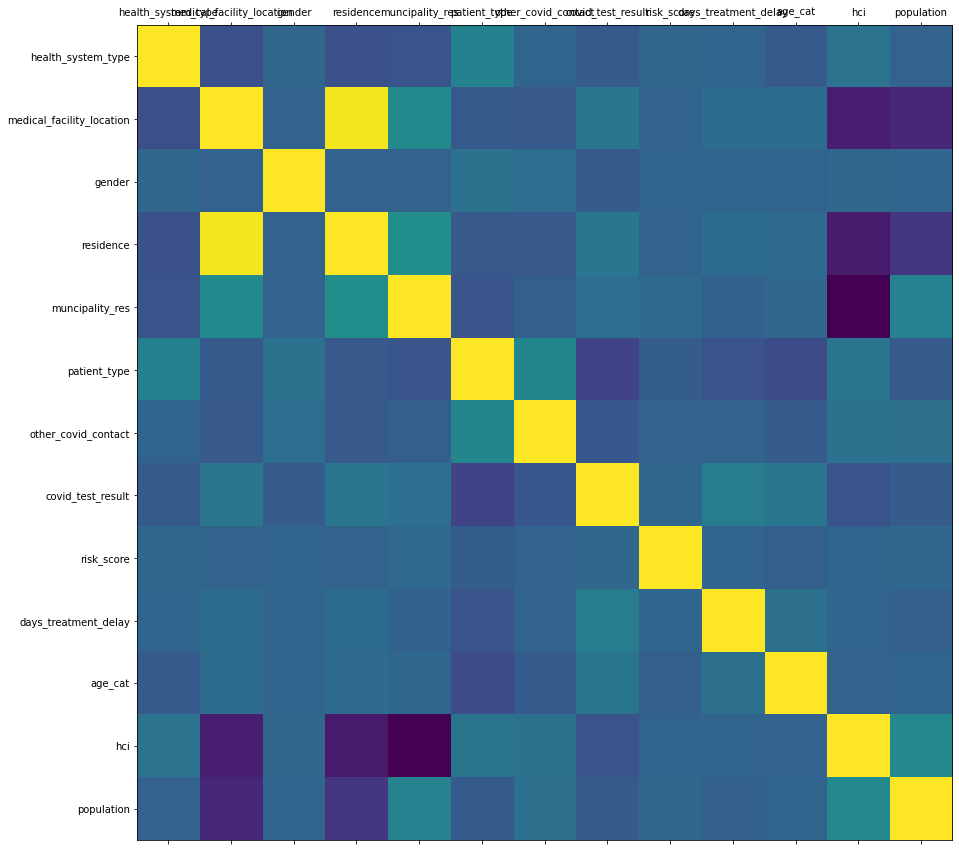

In [53]:
plot_corr(transformed_data)

Doesn't look like any features are related 1 to 1; so the correlations look good. There appear to be no correlated columns.

For example, if yellow appears more than once in a row, consider those two features to be correlated (i.e. related) and one feature could be removed.

In [54]:
transformed_data.corr()

,health_system_type,medical_facility_location,gender,residence,muncipality_res,patient_type,other_covid_contact,covid_test_result,risk_score,days_treatment_delay,age_cat,hci,population
health_system_type,1.000000,-0.117933,0.006831,-0.112379,-0.096496,0.167810,-0.004893,-0.062310,0.006507,0.001061,-0.061882,0.081086,-0.014408
medical_facility_location,-0.117933,1.000000,-0.015027,0.972252,0.229879,-0.061257,-0.069246,0.098412,-0.009015,0.042993,0.041117,-0.358534,-0.311965
gender,0.006831,-0.015027,1.000000,-0.016973,-0.008800,0.076545,0.052255,-0.051384,-0.005750,-0.001886,-0.005730,0.010904,0.004853
residence,-0.112379,0.972252,-0.016973,1.000000,0.249112,-0.064814,-0.067305,0.100078,-0.009124,0.045441,0.039722,-0.373967,-0.245657
muncipality_res,-0.096496,0.229879,-0.008800,0.249112,1.000000,-0.089365,-0.038494,0.058655,0.025438,-0.018037,0.017793,-0.480446,0.178317
patient_type,0.167810,-0.061257,0.076545,-0.064814,-0.089365,1.000000,0.201883,-0.175765,-0.043169,-0.100011,-0.134964,0.096416,-0.058889
other_covid_contact,-0.004893,-0.069246,0.052255,-0.067305,-0.038494,0.201883,1.000000,-0.076312,-0.008432,-0.011739,-0.049957,0.073306,0.063402
covid_test_result,-0.062310,0.098412,-0.051384,0.100078,0.058655,-0.175765,-0.076312,1.000000,0.008052,0.143769,0.094147,-0.094003,-0.053870
risk_score,0.006507,-0.009015,-0.005750,-0.009124,0.025438,-0.043169,-0.008432,0.008052,1.000000,0.000932,-0.034105,-0.005716,0.016388
days_treatment_delay,0.001061,0.042993,-0.001886,0.045441,-0.018037,-0.100011,-0.011739,0.143769,0.000932,1.000000,0.064622,0.002447,-0.024134


# Check class distribution
Rare events are hard to predict.

Check covid test result as a predictor variable to ensure adequate distribution of true and false cases.

In [55]:
num_obs = len(transformed_data)
num_true = len(transformed_data.loc[transformed_data['covid_test_result'] == 1])
num_false = len(transformed_data.loc[transformed_data['covid_test_result'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  319208 (43.88%)
Number of False cases: 408180 (56.12%)


# Splitting the data
80% for training, 20% for testing

In [57]:
transformed_data

,health_system_type,medical_facility_location,gender,residence,muncipality_res,patient_type,other_covid_contact,covid_test_result,risk_score,days_treatment_delay,age_cat,hci,population
0,3,15,0,15,106,0,0,1,1.82,-0.55,3,0.777,1.000000
1,3,2,0,2,2,0,1,1,1.55,-0.87,4,0.803,0.170663
2,3,27,0,27,4,1,1,1,1.73,2.01,3,0.768,0.100429
6,3,2,0,2,2,1,1,1,1.82,-1.19,3,0.803,0.170663
7,3,15,0,15,106,1,0,1,1.73,-0.55,3,0.777,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064135,12,9,0,9,17,1,1,0,1.55,-0.23,3,0.827,0.474340
1064136,12,15,1,15,13,1,1,0,1.73,-0.55,3,0.777,1.000000
1064137,12,21,0,21,114,1,1,0,1.82,1.05,3,0.737,0.332759
1064138,12,3,1,3,3,1,1,0,1.82,-0.55,3,0.799,0.004520


In [58]:
def Randomizing():
    df = transformed_data.reindex(np.random.permutation(data.index))


Randomizing()

In [59]:
transformed_data.describe()

,health_system_type,medical_facility_location,gender,residence,muncipality_res,patient_type,other_covid_contact,covid_test_result,risk_score,days_treatment_delay,age_cat,hci,population
count,727388.000000,727388.000000,727388.00000,727388.000000,727388.000000,727388.000000,727388.000000,727388.000000,727388.000000,727388.00000,727388.000000,727388.000000,727388.000000
mean,11.244222,15.657945,0.50549,15.906039,36.483628,0.873583,0.571324,0.438841,1.792252,0.00139,2.997982,0.780692,0.349416
std,2.068924,8.044143,0.49997,7.950859,47.737299,0.332319,0.494887,0.496246,0.367131,1.00137,0.493304,0.033132,0.276899
min,1.000000,1.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.910000,-1.19000,0.000000,0.692000,0.000000
25%,12.000000,9.000000,0.00000,9.000000,7.000000,1.000000,0.000000,0.000000,1.730000,-0.87000,3.000000,0.754000,0.136250
50%,12.000000,14.000000,1.00000,15.000000,20.000000,1.000000,1.000000,0.000000,1.820000,-0.23000,3.000000,0.777000,0.307729
75%,12.000000,23.000000,1.00000,23.000000,44.000000,1.000000,1.000000,1.000000,1.820000,0.41000,3.000000,0.799000,0.474340
max,99.000000,32.000000,1.00000,32.000000,570.000000,1.000000,1.000000,1.000000,19.270000,27.23000,4.000000,0.827000,1.000000


In [60]:
category_variables = ['health_system_type','medical_facility_location','muncipality_res','residence','age_cat']
predicted_class_names = ['covid_test_result']
transformed_data = pd.get_dummies(transformed_data,columns=category_variables)

In [61]:

from sklearn.model_selection import train_test_split

X = transformed_data.loc[:, transformed_data.columns != 'covid_test_result']     # predictor feature columns (5 X m)
y = transformed_data[predicted_class_names].values # predicted class (1=true, 0=false) column (1 X m)
split_test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size,random_state=42, shuffle=True) 


In [62]:
X_train

,gender,patient_type,other_covid_contact,risk_score,days_treatment_delay,hci,population,health_system_type_1,health_system_type_2,health_system_type_3,health_system_type_4,health_system_type_5,health_system_type_6,health_system_type_7,health_system_type_8,health_system_type_9,health_system_type_10,health_system_type_11,health_system_type_12,health_system_type_13,health_system_type_99,medical_facility_location_1,medical_facility_location_2,medical_facility_location_3,medical_facility_location_4,medical_facility_location_5,medical_facility_location_6,medical_facility_location_7,medical_facility_location_8,medical_facility_location_9,medical_facility_location_10,medical_facility_location_11,medical_facility_location_12,medical_facility_location_13,medical_facility_location_14,medical_facility_location_15,medical_facility_location_16,medical_facility_location_17,medical_facility_location_18,medical_facility_location_19,medical_facility_location_20,medical_facility_location_21,medical_facility_location_22,medical_facility_location_23,medical_facility_location_24,medical_facility_location_25,medical_facility_location_26,medical_facility_location_27,medical_facility_location_28,medical_facility_location_29,medical_facility_location_30,medical_facility_location_31,medical_facility_location_32,muncipality_res_1,muncipality_res_2,muncipality_res_3,muncipality_res_4,muncipality_res_5,muncipality_res_6,muncipality_res_7,muncipality_res_8,muncipality_res_9,muncipality_res_10,muncipality_res_11,muncipality_res_12,muncipality_res_13,muncipality_res_14,muncipality_res_15,muncipality_res_16,muncipality_res_17,muncipality_res_18,muncipality_res_19,muncipality_res_20,muncipality_res_21,muncipality_res_22,muncipality_res_23,muncipality_res_24,muncipality_res_25,muncipality_res_26,muncipality_res_27,muncipality_res_28,muncipality_res_29,muncipality_res_30,muncipality_res_31,muncipality_res_32,muncipality_res_33,muncipality_res_34,muncipality_res_35,muncipality_res_36,muncipality_res_37,muncipality_res_38,muncipality_res_39,muncipality_res_40,muncipality_res_41,muncipality_res_42,muncipality_res_43,muncipality_res_44,muncipality_res_45,muncipality_res_46,muncipality_res_47,muncipality_res_48,muncipality_res_49,muncipality_res_50,muncipality_res_51,muncipality_res_52,muncipality_res_53,muncipality_res_54,muncipality_res_55,muncipality_res_56,muncipality_res_57,muncipality_res_58,muncipality_res_59,muncipality_res_60,muncipality_res_61,muncipality_res_62,muncipality_res_63,muncipality_res_64,muncipality_res_65,muncipality_res_66,muncipality_res_67,muncipality_res_68,muncipality_res_69,muncipality_res_70,muncipality_res_71,muncipality_res_72,muncipality_res_73,muncipality_res_74,muncipality_res_75,muncipality_res_76,muncipality_res_77,muncipality_res_78,muncipality_res_79,muncipality_res_80,muncipality_res_81,muncipality_res_82,muncipality_res_83,muncipality_res_84,muncipality_res_85,muncipality_res_86,muncipality_res_87,muncipality_res_88,muncipality_res_89,muncipality_res_90,muncipality_res_91,muncipality_res_92,muncipality_res_93,muncipality_res_94,muncipality_res_95,muncipality_res_96,muncipality_res_97,muncipality_res_98,muncipality_res_99,muncipality_res_100,muncipality_res_101,muncipality_res_102,muncipality_res_103,muncipality_res_104,muncipality_res_105,muncipality_res_106,muncipality_res_107,muncipality_res_108,muncipality_res_109,muncipality_res_110,muncipality_res_111,muncipality_res_112,muncipality_res_113,muncipality_res_114,muncipality_res_115,muncipality_res_116,muncipality_res_117,muncipality_res_118,muncipality_res_119,muncipality_res_120,muncipality_res_121,muncipality_res_122,muncipality_res_123,muncipality_res_124,muncipality_res_125,muncipality_res_126,muncipality_res_127,muncipality_res_128,muncipality_res_129,muncipality_res_130,muncipality_res_131,muncipality_res_132,muncipality_res_133,muncipality_res_134,muncipality_res_135,muncipality_res_136,muncipality_res_137,muncipality_res_138,muncipality_res_139,muncipality_res_140,mu

In [63]:
y_train

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [64]:
X_test

,gender,patient_type,other_covid_contact,risk_score,days_treatment_delay,hci,population,health_system_type_1,health_system_type_2,health_system_type_3,health_system_type_4,health_system_type_5,health_system_type_6,health_system_type_7,health_system_type_8,health_system_type_9,health_system_type_10,health_system_type_11,health_system_type_12,health_system_type_13,health_system_type_99,medical_facility_location_1,medical_facility_location_2,medical_facility_location_3,medical_facility_location_4,medical_facility_location_5,medical_facility_location_6,medical_facility_location_7,medical_facility_location_8,medical_facility_location_9,medical_facility_location_10,medical_facility_location_11,medical_facility_location_12,medical_facility_location_13,medical_facility_location_14,medical_facility_location_15,medical_facility_location_16,medical_facility_location_17,medical_facility_location_18,medical_facility_location_19,medical_facility_location_20,medical_facility_location_21,medical_facility_location_22,medical_facility_location_23,medical_facility_location_24,medical_facility_location_25,medical_facility_location_26,medical_facility_location_27,medical_facility_location_28,medical_facility_location_29,medical_facility_location_30,medical_facility_location_31,medical_facility_location_32,muncipality_res_1,muncipality_res_2,muncipality_res_3,muncipality_res_4,muncipality_res_5,muncipality_res_6,muncipality_res_7,muncipality_res_8,muncipality_res_9,muncipality_res_10,muncipality_res_11,muncipality_res_12,muncipality_res_13,muncipality_res_14,muncipality_res_15,muncipality_res_16,muncipality_res_17,muncipality_res_18,muncipality_res_19,muncipality_res_20,muncipality_res_21,muncipality_res_22,muncipality_res_23,muncipality_res_24,muncipality_res_25,muncipality_res_26,muncipality_res_27,muncipality_res_28,muncipality_res_29,muncipality_res_30,muncipality_res_31,muncipality_res_32,muncipality_res_33,muncipality_res_34,muncipality_res_35,muncipality_res_36,muncipality_res_37,muncipality_res_38,muncipality_res_39,muncipality_res_40,muncipality_res_41,muncipality_res_42,muncipality_res_43,muncipality_res_44,muncipality_res_45,muncipality_res_46,muncipality_res_47,muncipality_res_48,muncipality_res_49,muncipality_res_50,muncipality_res_51,muncipality_res_52,muncipality_res_53,muncipality_res_54,muncipality_res_55,muncipality_res_56,muncipality_res_57,muncipality_res_58,muncipality_res_59,muncipality_res_60,muncipality_res_61,muncipality_res_62,muncipality_res_63,muncipality_res_64,muncipality_res_65,muncipality_res_66,muncipality_res_67,muncipality_res_68,muncipality_res_69,muncipality_res_70,muncipality_res_71,muncipality_res_72,muncipality_res_73,muncipality_res_74,muncipality_res_75,muncipality_res_76,muncipality_res_77,muncipality_res_78,muncipality_res_79,muncipality_res_80,muncipality_res_81,muncipality_res_82,muncipality_res_83,muncipality_res_84,muncipality_res_85,muncipality_res_86,muncipality_res_87,muncipality_res_88,muncipality_res_89,muncipality_res_90,muncipality_res_91,muncipality_res_92,muncipality_res_93,muncipality_res_94,muncipality_res_95,muncipality_res_96,muncipality_res_97,muncipality_res_98,muncipality_res_99,muncipality_res_100,muncipality_res_101,muncipality_res_102,muncipality_res_103,muncipality_res_104,muncipality_res_105,muncipality_res_106,muncipality_res_107,muncipality_res_108,muncipality_res_109,muncipality_res_110,muncipality_res_111,muncipality_res_112,muncipality_res_113,muncipality_res_114,muncipality_res_115,muncipality_res_116,muncipality_res_117,muncipality_res_118,muncipality_res_119,muncipality_res_120,muncipality_res_121,muncipality_res_122,muncipality_res_123,muncipality_res_124,muncipality_res_125,muncipality_res_126,muncipality_res_127,muncipality_res_128,muncipality_res_129,muncipality_res_130,muncipality_res_131,muncipality_res_132,muncipality_res_133,muncipality_res_134,muncipality_res_135,muncipality_res_136,muncipality_res_137,muncipality_res_138,muncipality_res_139,muncipality_res_140,mu

In [65]:
y_test

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [66]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(509171, 508) (509171, 1)
(218217, 508) (218217, 1)


We check to ensure we have the the desired 80% train, 20% test split of the data

In [67]:
print("{0:0.2f}% in training set".format((len(X_train)/len(transformed_data.index)) * 100))
print("{0:0.2f}% in test set".format((len(X_test)/len(transformed_data.index)) * 100))

70.00% in training set
30.00% in test set


# Naive Bayes
Predict probability of a negative COVID outcome

In [68]:
X_train.columns

Index(['gender', 'patient_type', 'other_covid_contact', 'risk_score',
       'days_treatment_delay', 'hci', 'population', 'health_system_type_1',
       'health_system_type_2', 'health_system_type_3',
       ...
       'residence_28', 'residence_29', 'residence_30', 'residence_31',
       'residence_32', 'age_cat_0', 'age_cat_1', 'age_cat_2', 'age_cat_3',
       'age_cat_4'],
      dtype='object', length=508)

In [69]:
from sklearn.naive_bayes import GaussianNB

# create Gaussian Naive Bayes model object 
nb_model = GaussianNB()

# train it with the data
nb_model.fit(X_train, y_train.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [70]:
#Make predictions.
preds = nb_model.predict(y_test)
print(preds)

[0 0 0 ... 1 0 0]


# Performance on Test Data

In [71]:
X_test

,gender,patient_type,other_covid_contact,risk_score,days_treatment_delay,hci,population,health_system_type_1,health_system_type_2,health_system_type_3,health_system_type_4,health_system_type_5,health_system_type_6,health_system_type_7,health_system_type_8,health_system_type_9,health_system_type_10,health_system_type_11,health_system_type_12,health_system_type_13,health_system_type_99,medical_facility_location_1,medical_facility_location_2,medical_facility_location_3,medical_facility_location_4,medical_facility_location_5,medical_facility_location_6,medical_facility_location_7,medical_facility_location_8,medical_facility_location_9,medical_facility_location_10,medical_facility_location_11,medical_facility_location_12,medical_facility_location_13,medical_facility_location_14,medical_facility_location_15,medical_facility_location_16,medical_facility_location_17,medical_facility_location_18,medical_facility_location_19,medical_facility_location_20,medical_facility_location_21,medical_facility_location_22,medical_facility_location_23,medical_facility_location_24,medical_facility_location_25,medical_facility_location_26,medical_facility_location_27,medical_facility_location_28,medical_facility_location_29,medical_facility_location_30,medical_facility_location_31,medical_facility_location_32,muncipality_res_1,muncipality_res_2,muncipality_res_3,muncipality_res_4,muncipality_res_5,muncipality_res_6,muncipality_res_7,muncipality_res_8,muncipality_res_9,muncipality_res_10,muncipality_res_11,muncipality_res_12,muncipality_res_13,muncipality_res_14,muncipality_res_15,muncipality_res_16,muncipality_res_17,muncipality_res_18,muncipality_res_19,muncipality_res_20,muncipality_res_21,muncipality_res_22,muncipality_res_23,muncipality_res_24,muncipality_res_25,muncipality_res_26,muncipality_res_27,muncipality_res_28,muncipality_res_29,muncipality_res_30,muncipality_res_31,muncipality_res_32,muncipality_res_33,muncipality_res_34,muncipality_res_35,muncipality_res_36,muncipality_res_37,muncipality_res_38,muncipality_res_39,muncipality_res_40,muncipality_res_41,muncipality_res_42,muncipality_res_43,muncipality_res_44,muncipality_res_45,muncipality_res_46,muncipality_res_47,muncipality_res_48,muncipality_res_49,muncipality_res_50,muncipality_res_51,muncipality_res_52,muncipality_res_53,muncipality_res_54,muncipality_res_55,muncipality_res_56,muncipality_res_57,muncipality_res_58,muncipality_res_59,muncipality_res_60,muncipality_res_61,muncipality_res_62,muncipality_res_63,muncipality_res_64,muncipality_res_65,muncipality_res_66,muncipality_res_67,muncipality_res_68,muncipality_res_69,muncipality_res_70,muncipality_res_71,muncipality_res_72,muncipality_res_73,muncipality_res_74,muncipality_res_75,muncipality_res_76,muncipality_res_77,muncipality_res_78,muncipality_res_79,muncipality_res_80,muncipality_res_81,muncipality_res_82,muncipality_res_83,muncipality_res_84,muncipality_res_85,muncipality_res_86,muncipality_res_87,muncipality_res_88,muncipality_res_89,muncipality_res_90,muncipality_res_91,muncipality_res_92,muncipality_res_93,muncipality_res_94,muncipality_res_95,muncipality_res_96,muncipality_res_97,muncipality_res_98,muncipality_res_99,muncipality_res_100,muncipality_res_101,muncipality_res_102,muncipality_res_103,muncipality_res_104,muncipality_res_105,muncipality_res_106,muncipality_res_107,muncipality_res_108,muncipality_res_109,muncipality_res_110,muncipality_res_111,muncipality_res_112,muncipality_res_113,muncipality_res_114,muncipality_res_115,muncipality_res_116,muncipality_res_117,muncipality_res_118,muncipality_res_119,muncipality_res_120,muncipality_res_121,muncipality_res_122,muncipality_res_123,muncipality_res_124,muncipality_res_125,muncipality_res_126,muncipality_res_127,muncipality_res_128,muncipality_res_129,muncipality_res_130,muncipality_res_131,muncipality_res_132,muncipality_res_133,muncipality_res_134,muncipality_res_135,muncipality_res_136,muncipality_res_137,muncipality_res_138,muncipality_res_139,muncipality_res_140,mu

# Predict values using the testing data

In [72]:
nb_predict_test = nb_model.predict(X_test)

from sklearn import metrics

# training metrics
print("nb_predict_test", nb_predict_test)
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_test)))

nb_predict_test [0 0 0 ... 0 0 0]
Accuracy: 0.5745


# Random Forest
Random Forest using decision trees.

In [73]:
from sklearn.ensemble import RandomForestClassifier

# Create random forest object
rf_model = RandomForestClassifier(max_depth=15,random_state=123, n_estimators=100) 

# Train model
rf_model.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

# Predict values using the testing data

In [74]:
# Predict Test Data
rf_predict_test = rf_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, rf_predict_test)))

Accuracy: 0.6417


In [75]:
print(metrics.confusion_matrix(y_test, rf_predict_test) )
print("TP,FP")
print("FN,TN")
print("")
print("Classification Report")
print(metrics.classification_report(y_test, rf_predict_test))

[[103901  18687]
 [ 59501  36128]]
TP,FP
FN,TN

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.85      0.73    122588
           1       0.66      0.38      0.48     95629

    accuracy                           0.64    218217
   macro avg       0.65      0.61      0.60    218217
weighted avg       0.65      0.64      0.62    218217




**Precision** is the ability of a classiifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”


**Recall** is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”


The **F1 score** is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

**Support** is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [76]:
y_test

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

# Logistic Regression


In [77]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plot
# create logistic regression object
lr_model=LogisticRegression(C=0.7, random_state=123, solver='liblinear', max_iter=1000)

# train model
lr_model.fit(X_train, y_train.ravel())
predY = lr_model.predict_proba(X_test)

# Predict values using the testing data

In [78]:
lr_predict_test = lr_model.predict(X_test)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_predict_test)))
print("TP,FP")
print("FN,TN")
print(metrics.confusion_matrix(y_test, lr_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_test))

Accuracy: 0.6393
TP,FP
FN,TN
[[97678 24910]
 [53805 41824]]

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.80      0.71    122588
           1       0.63      0.44      0.52     95629

    accuracy                           0.64    218217
   macro avg       0.64      0.62      0.61    218217
weighted avg       0.64      0.64      0.63    218217



# Determine the strength of the municipality_res feature

In [79]:
coef_dict = {}
for coef, feat in zip(lr_model.coef_[0],X_train.columns):
    coef_dict[feat] = coef

sort_orders = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

for i in sort_orders:
	print(i[0], i[1])

muncipality_res_158 -1.516870058529404
muncipality_res_229 -1.4247911648293814
muncipality_res_545 -1.3282431468275213
muncipality_res_539 1.281608470032116
muncipality_res_266 -1.2582162871449443
muncipality_res_516 -1.1883746812281026
muncipality_res_176 -1.1478763024767404
health_system_type_4 -1.1444585168812345
muncipality_res_447 -1.108427305956683
muncipality_res_467 -1.0960030309287658
muncipality_res_534 1.0734930831986729
muncipality_res_293 1.0702811328282673
muncipality_res_334 -1.0579292056649554
muncipality_res_409 0.9803737301650476
health_system_type_11 0.9705365661205428
medical_facility_location_22 0.9377795552515256
muncipality_res_171 0.9136983523767992
muncipality_res_178 0.900959289185143
medical_facility_location_29 -0.8986801755245306
muncipality_res_390 0.8974057832649428
muncipality_res_570 0.8968078908877453
muncipality_res_555 0.8954505085064088
muncipality_res_338 0.8897291210634056
muncipality_res_484 -0.8850840156269678
muncipality_res_499 -0.884864143745

In [80]:
def plot_dict(coef_dict):
  keys = coef_dict.keys()
  values = coef_dict.values()
  plt.bar(keys, values)

<BarContainer object of 389 artists>

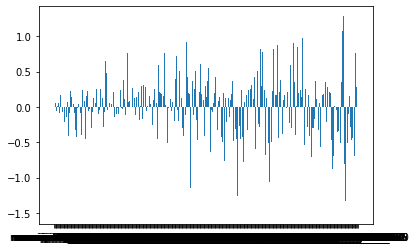

In [81]:
keys=[]
values=[]
muncipality={}
for key in coef_dict.keys():
  if 'muncipality' in key:
      value = coef_dict[key]
      if abs(value)>0:
        muncipality[key] = value
        values.append(value)
        keys.append(key)
      
plt.bar(keys, values) 


In [82]:
sort_orders = sorted(muncipality.items(), key=lambda x: abs(x[1]), reverse=True)

for i in sort_orders[:20]:
	print(i[0], i[1])

muncipality_res_158 -1.516870058529404
muncipality_res_229 -1.4247911648293814
muncipality_res_545 -1.3282431468275213
muncipality_res_539 1.281608470032116
muncipality_res_266 -1.2582162871449443
muncipality_res_516 -1.1883746812281026
muncipality_res_176 -1.1478763024767404
muncipality_res_447 -1.108427305956683
muncipality_res_467 -1.0960030309287658
muncipality_res_534 1.0734930831986729
muncipality_res_293 1.0702811328282673
muncipality_res_334 -1.0579292056649554
muncipality_res_409 0.9803737301650476
muncipality_res_171 0.9136983523767992
muncipality_res_178 0.900959289185143
muncipality_res_390 0.8974057832649428
muncipality_res_570 0.8968078908877453
muncipality_res_555 0.8954505085064088
muncipality_res_338 0.8897291210634056
muncipality_res_484 -0.8850840156269678


# **GRAPH THE MODEL EVALUATION RESULTS (ROC)**

 



The optimal point on the ROC curve is (FPR, TPR) = (0,1). No false positives and all true positives. So the closer we get there the better. 

In [83]:
fpr, tpr, thresh = metrics.roc_curve(y_test,predY[:,1])
auc = metrics.auc(fpr, tpr)
print("Area Under the Curve:", auc)

Area Under the Curve: 0.6755778891903081


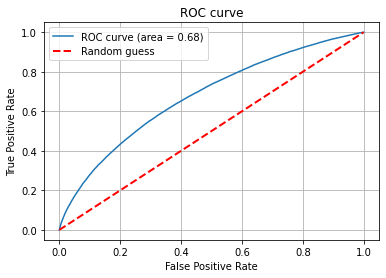

In [84]:
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

A diagonal line is a random guess that the model defines nonsense. If the curve approaches closer to the top-left corner, the model performance becomes much better. Any curve under the diagonal line is worse than a random guess.

# Using your trained Model

In [85]:
# save trained model to file
from sklearn.externals import joblib  

# saving the logistic regression Model
joblib.dump(lr_model, "./covid-trained-model.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['./covid-trained-model.pkl']

In [86]:
# load model

lr_model = joblib.load("./covid-trained-model.pkl")